In [1]:
import subprocess
from subprocess import PIPE
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import glob
from scipy.stats import spearmanr, zscore

sys.path.append("../../funcs/")

import signatureanalyzer as sa
import seaborn as sns
import proteomics as prot
import plotting as pl
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Save as GCTs for ssgSEA
sys.path.append("../../scripts/")

from diffexp_wrapper import write_gct
from write_ptmgsea_out import gen_ptmgsea_df
import matplotlib.gridspec as gridspec

In [132]:
PLOTS_DIR = "figures"
DATA_DIR = "../../data/processed/061721"
DATA_DIR_GC = "../../data/processed/061721_genecentric"
NMF_FILE = "../signatures/061721_imputed_res_reg/nmf_output.h5"
MAPPING_FILE = os.path.join(DATA_DIR, "PanCan_Participant_freeze_mapping.tsv")
LABELS = "../diffexp/061721_imputed_res_reg_dendro/full_dendro_sig_mappings.tsv"
OUT_DIR = "output"
GMT_DIR = "../../data/ref/gmts/"

os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

## 1. Load Matrices
---

In [133]:
samples_df = pd.read_csv(MAPPING_FILE, sep='\t')
labs_df = pd.read_csv(LABELS, sep='\t', index_col=0)
H_df = pd.read_hdf(NMF_FILE, "H")
meta_s = H_df.join(labs_df['cohort'])['cohort']
pmap_df = pd.read_csv(os.path.join(DATA_DIR, "var_map_full.tsv"), sep='\t', index_col=0)

/home/sanand/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (1,4,6,7,8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Load data matrices
rna_df = pd.read_parquet(os.path.join(DATA_DIR, "rna", "tumor_rna_tpm_norm_combat_X.parquet"))
prot_df = pd.read_csv(os.path.join(DATA_DIR_GC, "raw", "proteome_X.tsv.gz"), sep='\t', index_col=0)
phosph_df = pd.read_csv(os.path.join(DATA_DIR, "raw", "phosphoproteome_X.tsv.gz"), sep='\t', index_col=0)
acetyl_df = pd.read_csv(os.path.join(DATA_DIR, "raw", "acetylome_X.tsv.gz"), sep='\t', index_col=0)

# Subset appropriate samples
rna_df = rna_df[H_df.index]
prot_df = prot_df[H_df.index]
phosph_df = phosph_df[H_df.index]
acetyl_df = acetyl_df[np.intersect1d(H_df.index, acetyl_df.columns)]

In [5]:
rna_df.shape, acetyl_df.shape, prot_df.shape, phosph_df.shape

((29145, 1110), (30234, 572), (15699, 1110), (110274, 1110))

In [6]:
_prot_id = pd.DataFrame(prot_df.index, columns=['geneSymbol'])
_prot_id.index = _prot_id['geneSymbol']
_prot_id['feature'] = 'proteome'
_prot_id.index.name = 'id'

pmap_full_df = pd.concat([
    pmap_df,
    _prot_id
])

In [7]:
# Save for Deconvolution
rna_g_df = rna_df.join(pmap_full_df[['geneSymbol']]).set_index("geneSymbol")
rna_g_df = rna_g_df.loc[~rna_g_df.index.duplicated(),]
#rna_g_df.to_csv("output/rna_tpm_gene_name.tsv.gz", sep='\t')

# Write Z-score TPM Files
rna_g_z_df = pd.DataFrame(zscore(rna_g_df), index=rna_g_df.index, columns=rna_g_df.columns)
#rna_g_z_df.to_csv("output/rna_tpm_gene_name_zscore.tsv.gz", sep='\t')

# Write GCT Files
#write_gct(rna_g_z_df,labs_df.iloc[:,-3:],rna_g_z_df[[]],'ssgsea/rna_g_z.gct')
#write_gct(prot_df,labs_df.iloc[:,-3:],prot_df[[]],'ssgsea/prot_g.gct')

## 2. Compute Enrichments
---

In [8]:
mappings_df = pd.read_csv(LABELS, sep='\t', index_col=0)

In [9]:
def plot_ie(dat, x, y, ax=None, figsize=(6,6), **kwargs):
    """Plot immune enrichment."""
    if ax is None:
        fig,ax = plt.subplots(figsize=figsize)
    
    sns.violinplot(
        ax=ax,
        data=dat,
        x=x,
        y=y,
        **kwargs
    )
    
    ax.axhline(np.mean(dat[y]), c='black', linestyle=':', alpha=0.4, zorder=0)
    
def plot_immune_enrichments(dat, x, y, figsize=(20,8), **kwargs):
    """
    Plot immune enrichemnts.
    """
    fig,axes = plt.subplots(2,1,figsize=(20,8), sharex=True)
    
    plot_ie(dat[dat['feature']=='transcriptome'], x=x, y=y, ax=axes[0], **kwargs)
    plot_ie(dat[dat['feature']=='proteome'], x=x, y=y, ax=axes[1], **kwargs)
    
    axes[0].set_xlabel("")
    axes[1].set_xlabel("Signatures", fontsize=14)

    axes[0].set_ylabel("Transcriptome TReg (Newman)")
    axes[1].set_ylabel("Proteome TReg (Newman)")
    plt.tight_layout()
    
def create_GMT_from_dataframe(
    df, 
    outfile, 
    tag='Uniq_', 
    gene_idx='gene_symbol', 
    subtype_idx='subtype'
    ):
    """
    Create GMT from dataframe.
    ----------------------------
    Script to convert gene-sets to GMT files for pathway analysis.
    """
    sigs_df = df.dropna()
    
    with open(outfile, 'w') as f:
        for subtype in pd.unique(sigs_df[subtype_idx]):
            line_out = "{}\t{}\t".format(subtype,"custom")
            line_out += '\t'.join(sigs_df[sigs_df[subtype_idx]==subtype][gene_idx].values)
            f.write(line_out+'\n')
                
    print("   * saving to {}".format(outfile))

In [10]:
newman_pw = pd.read_csv(os.path.join(GMT_DIR, "staudt_2020_filt.txt"), sep='\t', usecols=[0], header=None)
newman_pw = [x for x in newman_pw[0] if x.endswith("Newman")]

In [11]:
# Create Unique Gene Sets
new_gene_sets = list()

for ciber in newman_pw:
    out_genes = list()
    for c in set(newman_pw)-{ciber}:
        out_genes += list(prot.pull_geneset_from_gmt(os.path.join(GMT_DIR, "staudt_2020_filt.txt"))[c])
    
    unique_g = set(prot.pull_geneset_from_gmt(os.path.join(GMT_DIR, "staudt_2020_filt.txt"))[ciber]) - set(out_genes)
    _df = pd.DataFrame(list(unique_g), columns=['genes'])
    _df['pathway'] = ciber
    new_gene_sets.append(_df)
    
ngs_df = pd.concat(new_gene_sets)

In [12]:
os.makedirs("ref", exist_ok=True)
create_GMT_from_dataframe(ngs_df, "ref/newman_gmt_unique.txt", gene_idx="genes", subtype_idx="pathway")

   * saving to ref/newman_gmt_unique.txt


In [13]:
dfs = list()

for pw in (
    'KEGG_FATTY_ACID_METABOLISM',
    'KEGG_BIOSYNTHESIS_OF_UNSATURATED_FATTY_ACIDS'):
    unique_g = list(prot.pull_geneset_from_gmt(os.path.join(GMT_DIR, "c2.cp.kegg.v7.0.symbols.gmt.txt"))[pw])
    _df = pd.DataFrame(list(unique_g), columns=['genes'])
    _df['pathway'] = pw
    dfs.append(_df)

for pw in (
    'HALLMARK_INTERFERON_ALPHA_RESPONSE',
    'HALLMARK_INTERFERON_GAMMA_RESPONSE',
    'HALLMARK_FATTY_ACID_METABOLISM',
    'HALLMARK_TNFA_SIGNALING_VIA_NFKB'):
    unique_g = list(prot.pull_geneset_from_gmt(os.path.join(GMT_DIR, "h.all.v7.0.symbols.gmt.txt"))[pw])
    _df = pd.DataFrame(list(unique_g), columns=['genes'])
    _df['pathway'] = pw
    dfs.append(_df)

dfs = pd.concat(dfs)

In [14]:
create_GMT_from_dataframe(dfs, "ref/ifng_fa_ha_kegg.txt", gene_idx="genes", subtype_idx="pathway")

   * saving to ref/ifng_fa_ha_kegg.txt


## 3. Load Deconvolution Results
---

Run `Rscript runImmuneDeconv.R` to compute immune deconvolution results.

In [97]:
outdir = "ImmuneDeconv"
resd = prot.loadImmuneDeconv(outdir)

# Save covariates (purity)
resd = prot.loadImmuneDeconv(outdir)
resd['ciber'].columns = resd['ciber'].columns.str.replace(" ","_")
_df = pd.read_csv("../signatures/061721_imputed_res_reg/mappings.tsv", index_col=0, sep='\t')
_df = _df.join(resd['estimate'][['ESTIMATEScore']]).join(resd['ciber'])
_df.to_csv("diffexp/covariates.tsv", sep='\t')

In [119]:
def _plot_immune_violin(x, ax, **kwargs):
    """Plot immune."""
    cluster_cdict={"ImmuneCool":'#73ABC9', "ImmuneWarm":'#F6A43E', "ImmuneCold":'#8A74C0', "ImmuneHot":'#B94A47'}

    pl.plot_strip(
        ciber_df.T.loc[[x]], 
        ciber_df['ImmuneClustC4'], 
        yax=x,
        ylim=(0, None),
        order=['ImmuneCold','ImmuneCool','ImmuneWarm','ImmuneHot'],
        color=cluster_cdict,
        ax=ax,
        **kwargs
    )
    ax.set_xlabel("")
    ax.set_ylabel(ax.get_ylabel(), fontsize=12)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


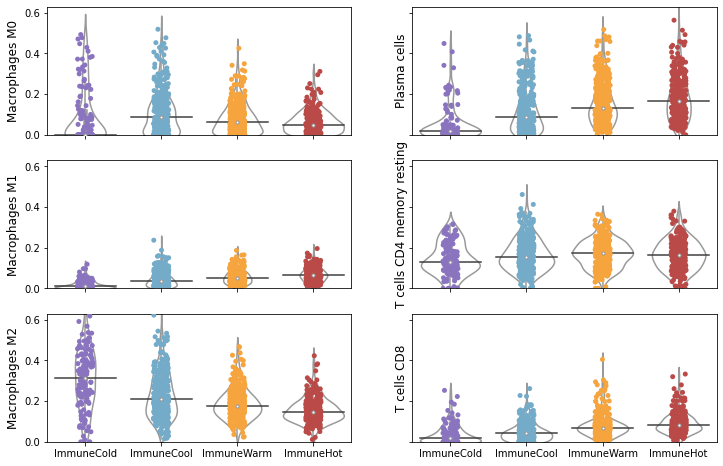

In [120]:
fig,axes = plt.subplots(3, 2, figsize=(12,8), sharey=True, sharex=True)

_plot_immune_violin("Macrophages M0", ax=axes[0,0])
_plot_immune_violin("Macrophages M1", ax=axes[1,0])
_plot_immune_violin("Macrophages M2", ax=axes[2,0])

_plot_immune_violin("Plasma cells", ax=axes[0,1])
_plot_immune_violin("T cells CD4 memory resting", ax=axes[1,1])
_plot_immune_violin("T cells CD8", ax=axes[2,1])

In [4]:
immune_de = resd['isc'][['BestCall']].join(resd['estimate']>0)
immune_de['BestCall'] = immune_de['BestCall'].str.replace(" ","_")

In [7]:
ssgsea_uniq_df, ssgsea_uniq_rna, ssgsea_uniq_prot = prot.load_ssgsea_results(
    "ssgsea_rna_z/ssgsea_rna_z-combined.gct", "ssgsea_prot/ssgsea_prot-combined.gct"
)

ssgsea_full_df, ssgsea_full_rna, ssgsea_full_prot = prot.load_ssgsea_results(
    "ssgsea_rna_z/ssgsea_rna_z_full-combined.gct", "ssgsea_prot/ssgsea_prot_full-combined.gct"
)

ssgsea_fa_df, ssgsea_fa_rna, ssgsea_fa_prot = prot.load_ssgsea_results(
    "ssgsea_rna_z/ssgsea_rna_z_fa_kegg_ha-combined.gct", "ssgsea_prot/ssgsea_prot_fa_kegg_ha-combined.gct"
)

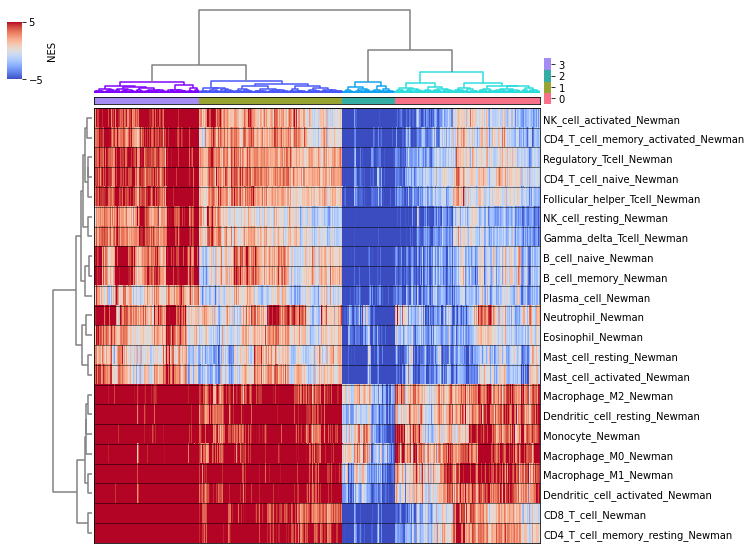

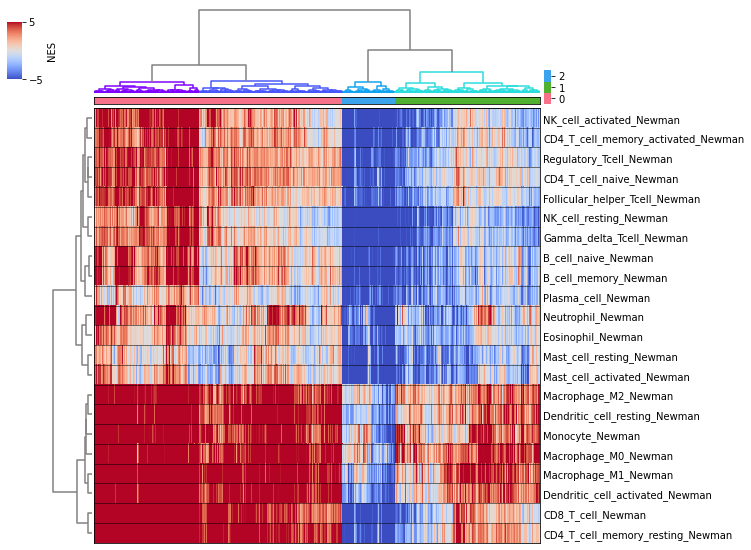

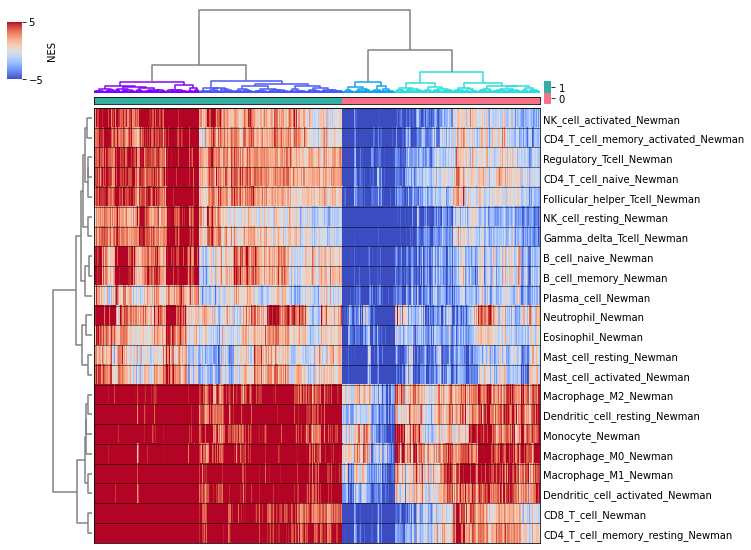

In [9]:
fig4, d4, forder4 = pl.plot_cluster_heatmap(
    ssgsea_full_rna.T,
    vmin=-5,
    vmax=5,
    cmap='coolwarm',
    n_clusters=4,
    cbar_label="NES"
)
plt.savefig(os.path.join(PLOTS_DIR, "ssgsea_heatmap_c4_clust.pdf"), dpi=100, bbox_inches='tight')

fig3, d3, forder3 = pl.plot_cluster_heatmap(
    ssgsea_full_rna.T,
    vmin=-5,
    vmax=5,
    cmap='coolwarm',
    n_clusters=3,
    cbar_label="NES"
)
plt.savefig(os.path.join(PLOTS_DIR, "ssgsea_heatmap_c3_clust.pdf"), dpi=100, bbox_inches='tight')

fig2, d2, forder2 = pl.plot_cluster_heatmap(
    ssgsea_full_rna.T,
    vmin=-5,
    vmax=5,
    cmap='coolwarm',
    n_clusters=2,
    cbar_label="NES"
)
plt.savefig(os.path.join(PLOTS_DIR, "ssgsea_heatmap_c2_clust.pdf"), dpi=100, bbox_inches='tight')

In [10]:
d4['clusters'] = d4['clusters'].astype(str)+"_c4"
d3['clusters'] = d3['clusters'].astype(str)+"_c3"
d2['clusters'] = d2['clusters'].astype(str)+"_c2"

In [11]:
immune_de = immune_de.join(
    d4[['clusters']].rename(columns={'clusters':'ssgsea_rna_c4'})).join(
    d3[['clusters']].rename(columns={'clusters':'ssgsea_rna_c3'})).join(
    d2[['clusters']].rename(columns={'clusters':'ssgsea_rna_c2'})
)

In [246]:
# Save for Differential expression
immune_de.to_csv("diffexp/061721_raw_res_immune/mappings.tsv", sep='\t')

## 3. Run Differential Expression
---

Run `run_immune_diffexp.py`.

In [19]:
raw_res_de_df = pd.read_csv("diffexp/061721_raw_res_immune/full_de_cohort_cov.tsv", sep='\t', index_col=0)
raw_de_df = pd.read_csv("diffexp/061721_raw_immune/full_de_cohort_cov.tsv", sep='\t', index_col=0)

# Combine Raw and Residualizsed PTM
raw_res_de_df['feature'] = raw_res_de_df['feature'].str.replace("acetylome","acetylome_res")
raw_res_de_df['feature'] = raw_res_de_df['feature'].str.replace("phosphoproteome","phosphoproteome_res")
immune_de_df = pd.concat((raw_res_de_df, raw_de_df))

/home/sanand/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (11,12,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [29]:
immune_de_df.to_csv("diffexp/061721_raw_res_immune/full_raw_and_res_de_cohort_cov.tsv")
immune_de_df.to_parquet("diffexp/061721_raw_res_immune/full_raw_and_res_de_cohort_cov.parquet")

In [ ]:
# Assign Names
_rename = {
    '0_c4':'ImmuneCool',
    '1_c4':'ImmuneWarm',
    '2_c4':'ImmuneCold', 
    '3_c4':'ImmuneHot'
}

immune_de['ImmuneClustC4'] = immune_de['ssgsea_rna_c4'].apply(lambda x: _rename[x])
immune_de.to_csv("diffexp/061721_raw_res_immune/mappings_labeled.tsv", sep='\t')

## 3.5 Compare Immune Subyptes
---

In [190]:
immune_subgroup_df = pd.read_csv("Immune_subtypes_Jan_2022.tsv", sep='\t', index_col=0)
immune_subtypes_df = pd.read_csv("diffexp/061721_raw_res_immune/mappings_labeled.tsv", sep='\t', index_col=0)
samples_map_df = samples_df.set_index("Proteome_Sample_ID").loc[immune_subtypes_df.index][['participant_id','cohort']]

# Add Immune
immune_subtypes_df = samples_map_df.join(immune_subtypes_df).drop(
    columns=['ssgsea_rna_c4','ssgsea_rna_c3','ssgsea_rna_c2']
).reset_index().set_index("participant_id").join(immune_subgroup_df).reset_index().set_index("Proteome_Sample_ID")

In [201]:
def plot_immune_subtype_comparison(df, cohort=None, figsize=(4,8)):
    """Plot immune subtypes comparison."""
    fig,axes = plt.subplots(2,1,figsize=(4,8),sharex=True)
    
    if cohort is not None:
        df = df[df['cohort']==cohort]

    mat = df.groupby(
        ['immune subtypes','ImmuneClustC4']
    ).size().unstack("immune subtypes").fillna(0).T

    mat.plot(
        kind='barh', 
        stacked=True, 
        color=[cluster_cdict[x] for x in mat],
        ax=axes[0],
        width=0.9,
        edgecolor='k'
    )
    axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axes[0].set_ylabel("")

    mat = df.groupby(
        ['ImmuneClustC4','immune subtypes']
    ).size().unstack("ImmuneClustC4").fillna(0).T
    #.loc[['ImmuneCold','ImmuneCool','ImmuneWarm','ImmuneHot']]

    mat.plot(
        kind='barh', 
        stacked=True, 
        ax=axes[1],
        width=0.9,
        edgecolor='k',
    )
    axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axes[1].set_ylabel("")

In [1]:
def plot_immune_subtype_comparison(df, cohort=None, figsize=(4,8)):
    """Plot immune subtypes comparison."""
    fig,axes = plt.subplots(2,1,figsize=(4,8),sharex=True)
    
    if cohort is not None:
        df = df[df['cohort']==cohort]

    mat = df.groupby(
        ['immune subtypes','ImmuneClustC4']
    ).size().unstack("immune subtypes").fillna(0).T

    mat.plot(
        kind='barh', 
        stacked=True, 
        color=[cluster_cdict[x] for x in mat],
        ax=axes[0],
        width=0.9,
        hue='cohort',
        edgecolor='k'
    )
    axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axes[0].set_ylabel("")

    mat = df.groupby(
        ['ImmuneClustC4','immune subtypes']
    ).size().unstack("ImmuneClustC4").fillna(0).T
    #.loc[['ImmuneCold','ImmuneCool','ImmuneWarm','ImmuneHot']]

    mat.plot(
        kind='barh', 
        stacked=True, 
        ax=axes[1],
        width=0.9,
        edgecolor='k',
    )
    axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axes[1].set_ylabel("")

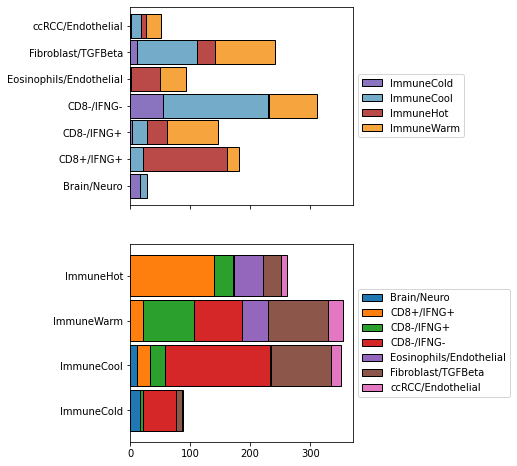

In [197]:
plot_immune_subtype_comparison(immune_subtypes_df)
plt.savefig(os.path.join(PLOTS_DIR, "immune_subtype_comparison.pdf"), dpi=100, bbox_inches='tight')

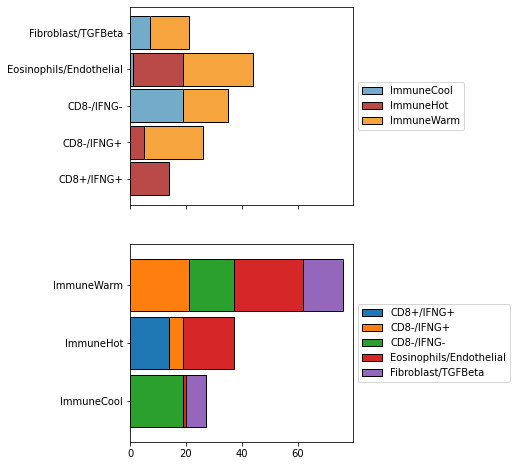

In [202]:
plot_immune_subtype_comparison(immune_subtypes_df, cohort="PDAC")

In [188]:
pl.plot_sankey(immune_subtypes_df, var1='immune subtypes', var2='ImmuneClustC4')

In [189]:
immune_subtypes_df

participant_id             BestCall  StromalScore  \
Proteome_Sample_ID                                                     
C01CO005                  01CO005        Wound_Healing         False   
C01CO006                  01CO006         Inflammatory          True   
C01CO008                  01CO008         Inflammatory         False   
C01CO013                  01CO013        Wound_Healing         False   
C01CO014                  01CO014            IFN-Gamma         False   
...                           ...                  ...           ...   
X21BR001                  21BR001            IFN-Gamma          True   
X21BR002                  21BR002             TGF-Beta          True   
X21BR010                  21BR010  Lymphocyte_Depleted          True   
X22BR005                  22BR005            IFN-Gamma          True   
X22BR006                  22BR006         Inflammatory          True   

                    ImmuneScore  ESTIMATEScore ImmuneClustC4  \
Proteome_Sample_ID                                             
C01CO005                  False          False    ImmuneCool   
C01CO006                   True           True     ImmuneHot   
C01CO008                   True          False    ImmuneCool   
C01CO013                   True           True    ImmuneWarm   
C01CO014                   True           True    ImmuneWarm   
...                         ...            ...           ...   
X21BR001                   True           True     ImmuneHot   
X21BR002                   True           True    ImmuneWarm   
X21BR010                   True           True    ImmuneCold   
X22BR005                   True           True    ImmuneWarm   
X22BR006                   True           True    ImmuneWarm   

                       immune subtypes    cluster  
Proteome_Sample_ID                                 
C01CO005                    CD8-/IFNG-  Cluster 4  
C01CO006                    CD8+/IFNG+  Cluster 5  
C01CO008                    CD8-/IFNG-  Cluster 4  
C01CO013                    CD8-/IFNG-  Cluster 4  
C01CO014                    CD8-/IFNG-  Cluster 4  
...                                ...        ...  
X21BR001                    CD8+/IFNG+  Cluster 5  
X21BR002                    CD8+/IFNG+  Cluster 5  
X21BR010            Fibroblast/TGFBeta  Cluster 1  
X22BR005                    CD8-/IFNG-  Cluster 4  
X22BR006            Fibroblast/TGFBeta  Cluster 1  

[1110 rows x 8 columns]

## 4. Aggregate Survival Data
---


In [54]:
clin_df = pd.read_csv("../../data/raw/clinical/clinical_Pan-cancer.Apr2021.tsv", sep='\t').set_index("case_id")
clin_df = clin_df.join(samples_df.set_index("participant_id")[['Proteome_Sample_ID']]).dropna(subset=['Proteome_Sample_ID']).reset_index().set_index("Proteome_Sample_ID")

In [68]:
cats = {
    'Overall survival, days':'oscdy',
    'Recurrence status (1, yes; 0, no)':'recurrence_status',
    'Survival status (1, dead; 0, alive)':'survival_status',
    'baseline/tumor_stage_pathological':'baseline_tumor_stage_pathological'
}

In [77]:
clin_df = clin_df[cats.keys()].rename(columns=cats).join(immune_de).join(labs_df)
clin_df = clin_df.dropna(subset=['max_id'])

In [79]:
clin_df.to_csv("output/survival_data.tsv", sep='\t')

In [94]:
set(clin_df['cohort'])

{'BRCA', 'CCRCC', 'COAD', 'GBM', 'HNSCC', 'LSCC', 'LUAD', 'OV', 'PDAC', 'UCEC'}

In [111]:
labs_df[labs_df['23'].notna()].groupby(['23','cohort']).size()

23     cohort
False  CCRCC      1
       HNSCC      4
       LSCC       3
       LUAD      33
       PDAC       3
       UCEC      11
True   GBM        2
       HNSCC      3
       LSCC      12
       LUAD       8
       OV         1
       UCEC       3
dtype: int64

In [185]:
cluster_cdict={"ImmuneCool":'#73ABC9', "ImmuneWarm":'#F6A43E', "ImmuneCold":'#8A74C0', "ImmuneHot":'#B94A47'}

mat = immune_de.join(labs_df['cohort']).groupby(
    ['cohort','ImmuneClustC4']).size().unstack("cohort").fillna(0).T

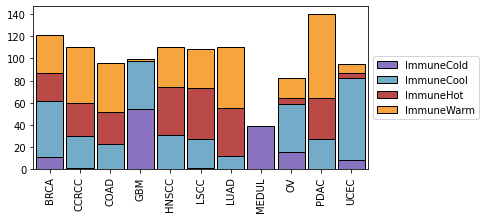

In [202]:
fig,ax = plt.subplots(figsize=(6,3))

mat.plot(
    kind='bar', 
    stacked=True, 
    color=[cluster_cdict[x] for x in mat],
    ax=ax,
    width=0.9,
    edgecolor='k'
)
ax.set_xlim(ax.get_xlim()[0]+0.15, ax.get_xlim()[1]-.15)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels())
plt.savefig(os.path.join(PLOTS_DIR, "immune_clust_per_cohort.pdf"), dpi=100, bbox_inches='tight')

## 4. Cohort Wide Comparisons
---

In [422]:
def plot_immune_deconv_strip(
    df, 
    x='cohort', 
    y='NES',
    hue='feature',
    figsize=(14,4), 
    ax=None, 
    ylab=None,
    yfontsize=16,
    xfontsize=14,
    plot_violin=False,
    remove_legend=True, 
    **kwargs
    ):
    """
    Violin.
    """
    if ax is None:
        fig,ax = plt.subplots(figsize=figsize)
    
    sns.stripplot(
        data=df,
        x=x,
        y=y,
        hue=hue,
        ax=ax,
        dodge=True,
        s=8,
        edgecolor='black',
        linewidth=.2,
        order=np.unique(df[x]),
        rasterized=True,
        **kwargs
    )

    capprops = dict(linewidth=0, color='white')
    sns.boxplot(
        x=x,
        y=y,
        hue=hue,
        data=df,
        ax=ax,
        showfliers=False,
        showbox=False,
        whis=0,
        capprops=capprops,
        order=np.unique(df[x]),
    )
    
    if plot_violin:
        sns.violinplot(
            x=x,
            y=y,
            data=df,
            hue=hue,
            ax=ax,
            alpha=0.1,
            color='white',
            order=np.unique(df[x]),
            labels=None
        )

    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=xfontsize)
    
    if remove_legend: 
        ax.legend().remove()
    else:
        pass
        
    
    if ylab is None:
        ax.set_ylabel(y, fontsize=yfontsize)
    else:
        ax.set_ylabel(ylab, fontsize=yfontsize)

No handles with labels found to put in legend.


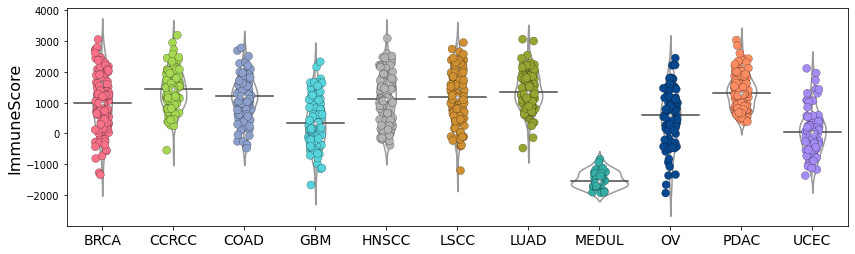

In [393]:
plot_immune_deconv_strip(
    resd['estimate'].join(mappings_df['cohort']), 
    y="ImmuneScore", 
    #palette={x.lower():y for x,y in pl.PTM_SCHEME2.items()},
    palette=pl.COLOR_SCHEME_NAME,
    plot_violin=True,
    hue=None
)

[Text(0, 0, 'HALLMARK_FATTY_ACID_METABOLISM'),
 Text(0, 0, 'HALLMARK_INTERFERON_ALPHA_RESPONSE'),
 Text(0, 0, 'HALLMARK_INTERFERON_GAMMA_RESPONSE'),
 Text(0, 0, 'HALLMARK_TNFA_SIGNALING_VIA_NFKB'),
 Text(0, 0, 'KEGG_BIOSYNTHESIS_OF_UNSATURATED_FATTY_ACIDS'),
 Text(0, 0, 'KEGG_FATTY_ACID_METABOLISM')]

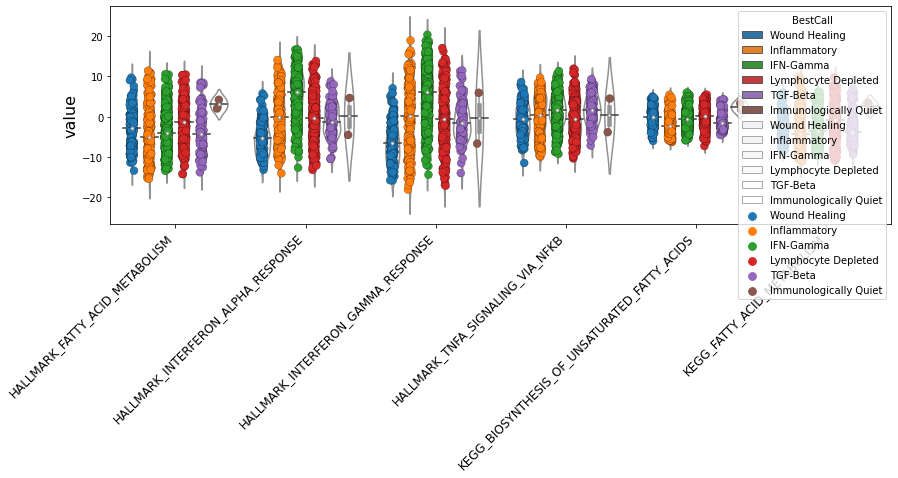

In [423]:
fig,ax = plt.subplots(figsize=(14,4))

plot_immune_deconv_strip(
    ssgsea_fa_prot_mat.reset_index().melt(id_vars='id').set_index('id').join(resd['isc']['BestCall']),
    x="pathway",
    y='value',
    plot_violin=True,
    hue='BestCall',
    remove_legend=False,
    ax=ax
)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=45, ha='right')

In [301]:
resd['isc'] = resd['isc'].join(mappings_df['cohort'])

In [ ]:
# remove immunologically quiet
# dig into phospho/acetylation changes

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


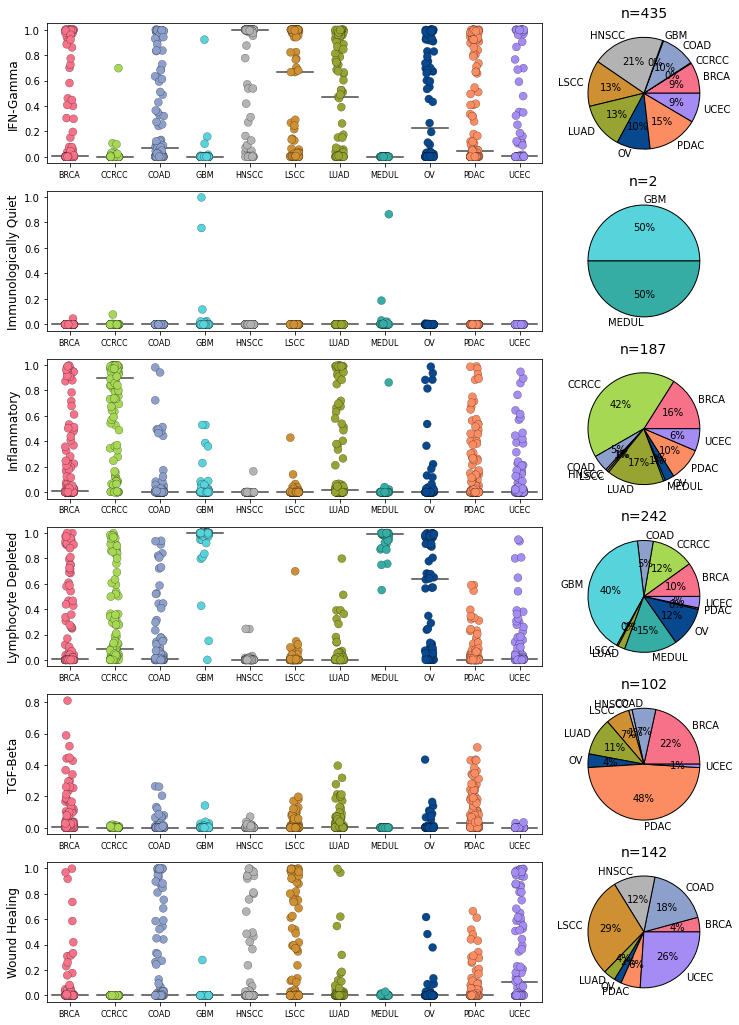

In [302]:
signatures =  np.unique(resd['isc']['BestCall'])
n_signatures = signatures.shape[0]

fig = plt.figure(figsize=(12, 3*n_signatures))
gs = fig.add_gridspec(n_signatures,4)

for idx,x in enumerate(signatures):
    ax1 = fig.add_subplot(gs[idx,:3])
    ax2 = fig.add_subplot(gs[idx,3:])
    
    plot_immune_deconv_strip(
        resd['isc'], 
        y=x, 
        hue=None, 
        palette=pl.COLOR_SCHEME_NAME, 
        ax=ax1,
        yfontsize=12,
        xfontsize=8,
        plot_violin=False,
    )
    
    _gb = resd['isc'][resd['isc']['BestCall']==x].groupby('cohort').size()

    ax2.pie(
        _gb.values, 
        labels=_gb.index, 
        colors=[pl.COLOR_SCHEME_NAME[x] for x in _gb.index], 
        autopct='%.0f%%',
        wedgeprops={"edgecolor":"k",'linewidth': 1}
    )
    ax2.set_title("n={}".format(_gb.sum()), fontsize=14)
    
plt.savefig(os.path.join(PLOTS_DIR, "isc_pancan_strip.pdf"), dpi=300, bbox_inches='tight')

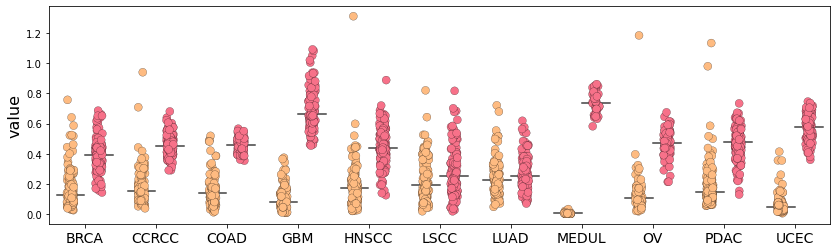

In [118]:
plot_immune_deconv_strip(xcell_df[xcell_df['pathway']=="ImmuneScore"], y="value")

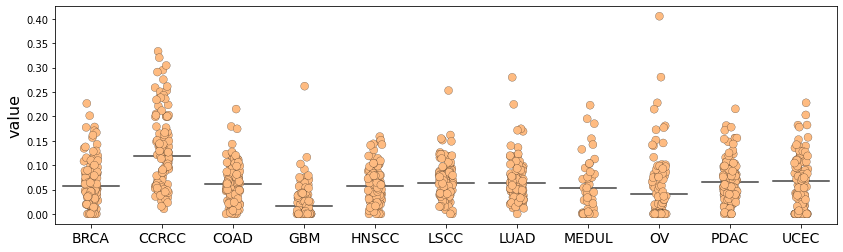

In [120]:
plot_immune_deconv_strip(ciber_df[ciber_df['pathway']=="T cells CD8"], y="value")

In [113]:
estimate_df[estimate_df["ImmuneScore"]<0].groupby('cohort').size()

cohort
BRCA     14
CCRCC     1
COAD      7
GBM      32
HNSCC    10
LSCC     11
LUAD      2
MEDUL    39
OV       19
UCEC     44
dtype: int64

### Consensus Cluster Plus

In [26]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

readRDS = robjects.r['readRDS']
X = readRDS("xCell_CCP/results.rds")

/home/sanand/anaconda3/envs/py37/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [65]:
sample_id = pd.read_csv("output/cptac_xcell.tsv", sep='\t').columns

In [131]:
def load_ccp_result(output_path):
    """
    Load ConsensusClusterPlus results.
    ---
    Args:
        * output_path
        * input_path
    """
    import rpy2.robjects as robjects
    from rpy2.robjects import pandas2ri
    pandas2ri.activate()
    
    readRDS = robjects.r['readRDS']
    X = readRDS(output_path)
    result = {}
    
    for i in range(1,len(X)):
        results_i = {}
        
        # Consensus matrix
        cm_df = pd.DataFrame(X[i][0], index=sample_id, columns=sample_id)

        results_i['cm'] = cm_df
        
        # Annot
        annot_s = pd.Series(X[i][2])
        annot_s.index = sample_id
        results_i['annot'] = annot_s
        
        result[i] = results_i
    
    return result

def plot_ccp_heatmap(result, idx):
    """
    Plot CCP heatmap.
    """
    import signatureanalyzer as sa
    import scipy.cluster.hierarchy as shc
    import scipy
    import signatureanalyzer as sa

    cm_df = result[idx]['cm']
    annot_s = result[idx]['annot'].astype(str)
    
    # Compute linkage
    linkage = shc.linkage(shc.distance.squareform(1-cm_df.values), method='average')
    _s, _cmap = sa.pl.series_to_colors(result[idx]['annot'])
    
    fg = sns.clustermap(
        cm_df,
        row_colors=[_s],
        col_colors=[_s],
        xticklabels=[],
        yticklabels=[],
        col_linkage=linkage,
        row_linkage=linkage,
        rasterized=True
    )
    
    ax = fg.ax_heatmap
    ax.set_ylabel("")
    
    dres = shc.dendrogram(linkage, no_plot=True)
    dgram_idx = list(map(int, dres['ivl']))
    
    return ax, annot_s.iloc[dgram_idx]

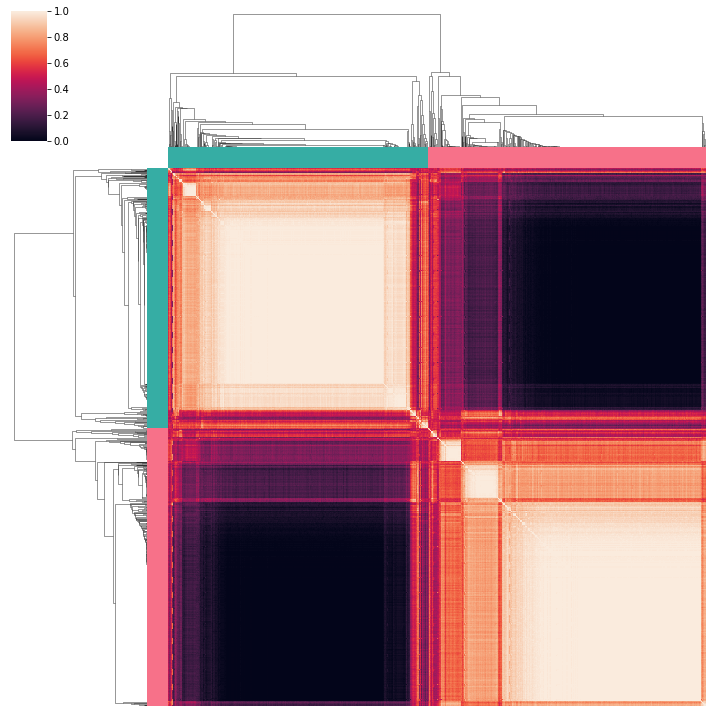

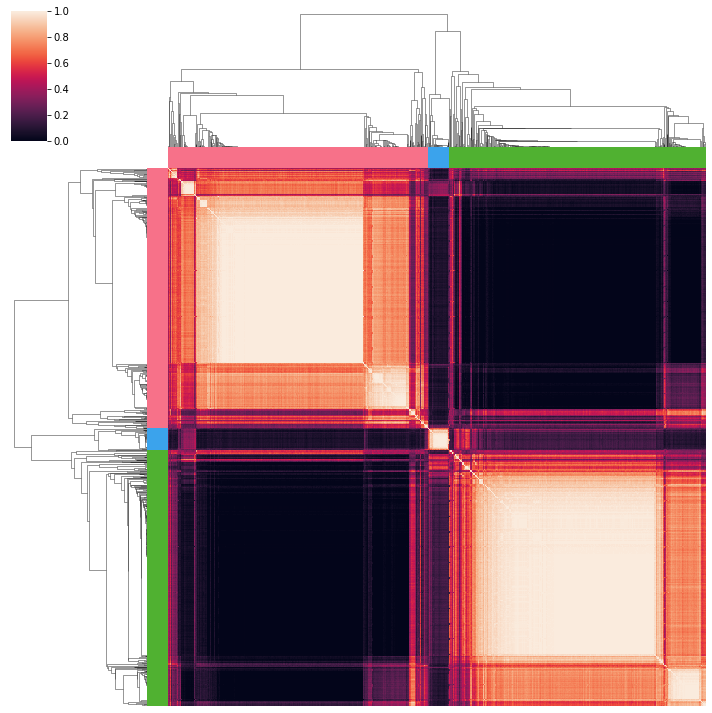

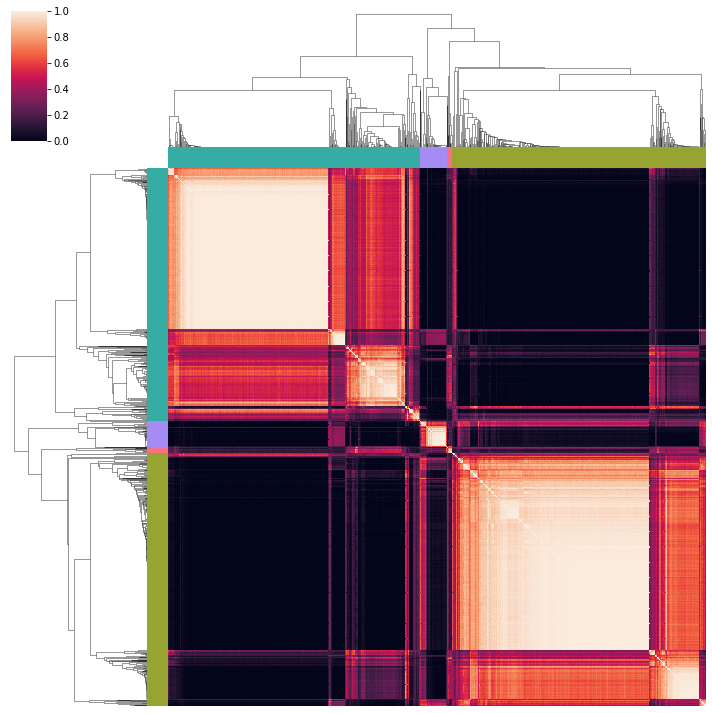

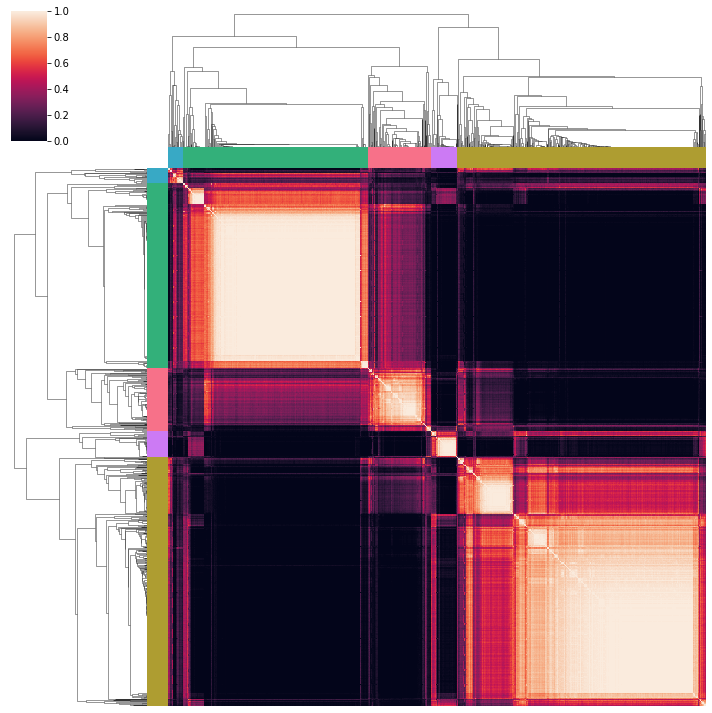

In [138]:
#result = load_ccp_result("xCell_CCP/results.rds")   
_, annot_s = plot_ccp_heatmap(result, 1)
annot_s.to_csv("ccp_2.tsv", sep='\t')

_, annot_s = plot_ccp_heatmap(result, 2)
annot_s.to_csv("ccp_3.tsv", sep='\t')

_, annot_s = plot_ccp_heatmap(result, 3)
annot_s.to_csv("ccp_4.tsv", sep='\t')

_, annot_s = plot_ccp_heatmap(result, 4)
annot_s.to_csv("ccp_5.tsv", sep='\t')

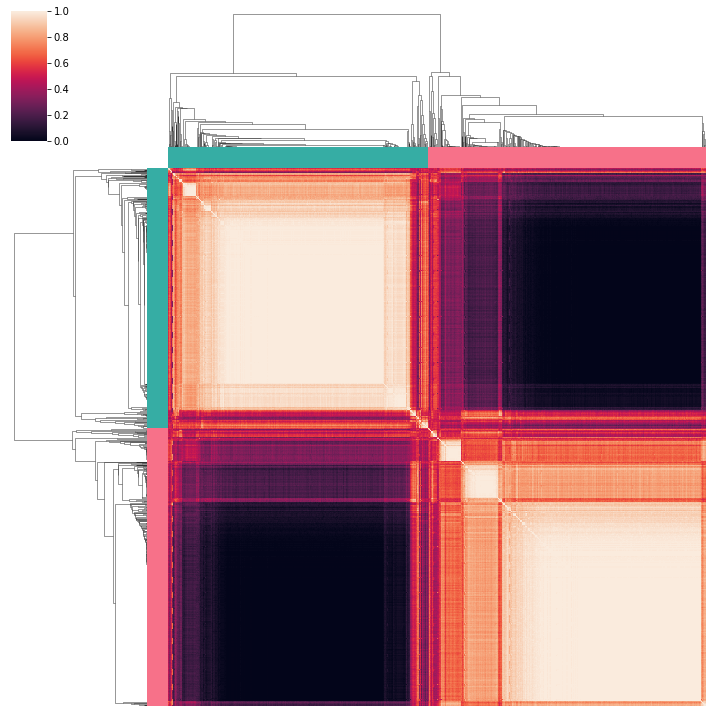

In [139]:
_, annot_s = plot_ccp_heatmap(result, 1)

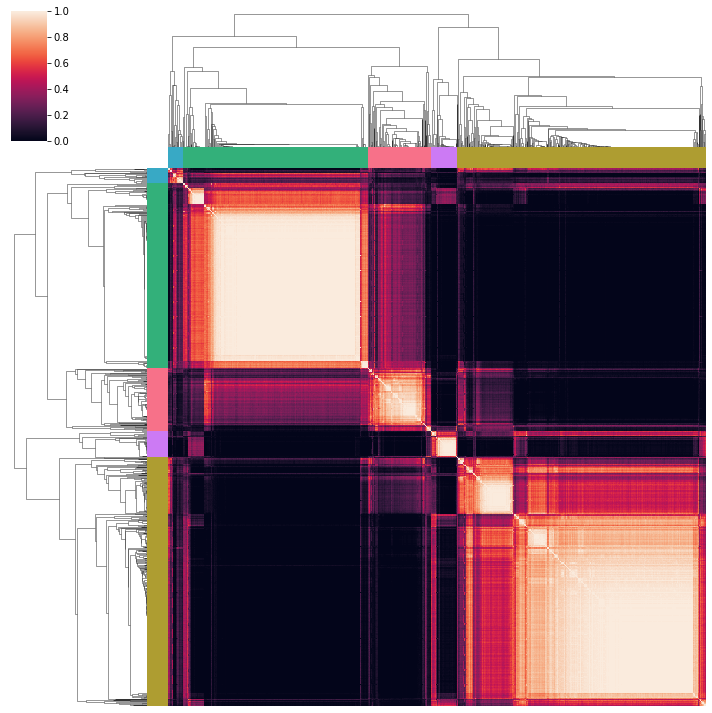

In [160]:
_, annot_s = plot_ccp_heatmap(result, 4)
annot_s.name = "immuno_group"